# Introduction
This notebook explores trends in property prices using historical data. The goal is to understand how property prices are distributed, how they have changed over time, and how they vary between different types of properties. We use graphs like histograms, box plots, and line charts to show these patterns in a clear way. 

In addition, we build and test two prediction models—Linear Regression and Decision Tree Regression—to estimate property prices and see how well they perform. This notebook provides a mix of data insights and predictions to better understand the housing market.

In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.tree import DecisionTreeRegressor



## Loading the Project Root and start of cleaning
Filtering out the dataset the entries of 2014 till 2017. All in London.

In [264]:
# # Load the Kaggle dataset
# file_path = './Price_paid_records.csv'  # Update with your dataset path
# data = pd.read_csv(file_path)

# # Convert 'Date of Transfer' to datetime for filtering
# data['Date of Transfer'] = pd.to_datetime(data['Date of Transfer'], errors='coerce')

# # Filter the data for the date range (2014-01-01 to 2017-12-31) and city is London
# start_date = '2014-01-01'
# end_date = '2017-12-31'

# filtered_data = data[
#     (data['Date of Transfer'] >= start_date) &
#     (data['Date of Transfer'] <= end_date) &
#     (data['Town/City'].str.upper() == 'LONDON')  # Case insensitive match for "London"
# ]

# # Display the filtered data
# print(filtered_data.head())
# print(f"Number of rows in filtered data: {len(filtered_data)}")

# # Save the filtered data to a new CSV file
# filtered_file_path = './london_transactions_2014_2017.csv'
# filtered_data.to_csv(filtered_file_path, index=False)
# print(f"Filtered data saved to: {filtered_file_path}")


This block of code is focused on **loading, filtering, and saving a dataset related to house transactions in London**. Initially, it imports the dataset from a specified file path (`Price_paid_records.csv`) and parses the `Date of Transfer` column into a datetime format, ensuring that it can be accurately filtered by date. The dataset is then narrowed down to include only transactions from January 1, 2014, to December 31, 2017, and restricted to entries where the city is identified as "London" (case-insensitive). Once filtered, the code previews the data by displaying the first few rows and the total number of filtered entries. Finally, the cleaned and narrowed dataset is saved into a new CSV file named `london_transactions_2014_2017.csv`, allowing it to be used in subsequent analysis steps.

### Handeling Missing data and Outliers

This block of code focuses on improving the dataset's quality and usability by handling missing data, identifying and removing outliers, converting data types, and performing feature engineering. Each step ensures that the data is clean and prepared for further analysis or modeling.

First, missing data is handled systematically. The code checks for null values in all columns and displays a summary. Rows with missing values in the critical Price column are dropped to maintain data integrity, as this is a key variable for analysis. For other columns, missing values are filled with placeholder values, such as 'Unknown' for the Property Type column, ensuring no essential information is lost while maintaining the dataset's completeness.

Next, the code addresses outliers in the Price column using the Interquartile Range (IQR) method. This statistical approach calculates the 30th percentile (Q1) and 70th percentile (Q3) of the price data to define a range of acceptable values. Any values outside the lower and upper bounds of this range are considered outliers and removed. This step ensures that extreme values do not distort the analysis or any predictive modeling later.

Following this, the Date of Transfer column is converted into a datetime format, facilitating time-based operations. From this, new features are engineered by extracting the year, month, and day into separate columns. These additional features can help uncover seasonal patterns or long-term trends in the housing market.

Finally, the cleaned dataset is verified by displaying a preview of the data, the data types of each column, and the overall dimensions of the dataset. After cleaning, the dataset contains 220,798 rows and 14 columns. This process not only ensures that the dataset is free from inconsistencies but also enriches it with new features for advanced analysis.

In [265]:
# Load the cleaned data
cleaned_file_path = './london_transactions_2014_2017.csv'
data = pd.read_csv(cleaned_file_path)

# Step 1: Handle Missing Data
# Check for missing values
missing_data = data.isnull().sum()
print(f"Missing data:\n{missing_data}")

# Handle missing values
# For simplicity, let's drop rows with missing target variable 'Price'
data = data.dropna(subset=['Price'])

# If there are other columns with missing values, you can either fill them or drop them
# Example: Fill missing values in 'property_type' with a placeholder value
data['Property Type'] = data['Property Type'].fillna('Unknown')

# Step 2: Handle Outliers
# Using the IQR method to detect outliers in the 'Price' column
Q1 = data['Price'].quantile(0.30)
Q3 = data['Price'].quantile(0.70)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers for Price
data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

# Step 3: Convert Data Types
# Convert 'Date of Transfer' to datetime format
data['Date of Transfer'] = pd.to_datetime(data['Date of Transfer'])

# Step 4: Feature Engineering
# Extract year, month, and day from 'Date of Transfer'
data['Year'] = data['Date of Transfer'].dt.year
data['Month'] = data['Date of Transfer'].dt.month
data['Day'] = data['Date of Transfer'].dt.day

# Step 5: Verify the cleaned data
print(f"Cleaned data head:\n{data.head()}")
print(f"Data types:\n{data.dtypes}")
print(f"Data after cleaning: {data.shape}")


Missing data:
Transaction unique identifier        0
Price                                0
Date of Transfer                     0
Property Type                        0
Old/New                              0
Duration                             0
Town/City                            0
District                             0
County                               0
PPDCategory Type                     0
Record Status - monthly file only    0
dtype: int64
Cleaned data head:
            Transaction unique identifier   Price Date of Transfer  \
0  {63BF6C16-3D4E-41DF-920B-D1BC6A4A9096}  830000       2014-10-27   
1  {AC191476-E72A-4F60-A1D6-CE290823126C}  800000       2014-12-22   
2  {540A0436-5C28-4D6B-ABDE-D1BD07E7E01E}  560500       2014-09-18   
4  {B8167567-68CB-449E-B3DE-D5461003AD16}  682500       2014-06-20   
5  {5144B639-A442-4635-BAFC-D1BD5126A051}  360000       2014-07-24   

  Property Type Old/New Duration Town/City             District  \
0             D       N        F    L

### Some visualisations of the current Dataset

In [266]:
data.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Year,Month,Day
0,{63BF6C16-3D4E-41DF-920B-D1BC6A4A9096},830000,2014-10-27,D,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,10,27
1,{AC191476-E72A-4F60-A1D6-CE290823126C},800000,2014-12-22,S,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,12,22
2,{540A0436-5C28-4D6B-ABDE-D1BD07E7E01E},560500,2014-09-18,T,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,9,18
4,{B8167567-68CB-449E-B3DE-D5461003AD16},682500,2014-06-20,F,N,L,LONDON,CITY OF WESTMINSTER,GREATER LONDON,A,A,2014,6,20
5,{5144B639-A442-4635-BAFC-D1BD5126A051},360000,2014-07-24,F,Y,L,LONDON,GREENWICH,GREATER LONDON,A,A,2014,7,24


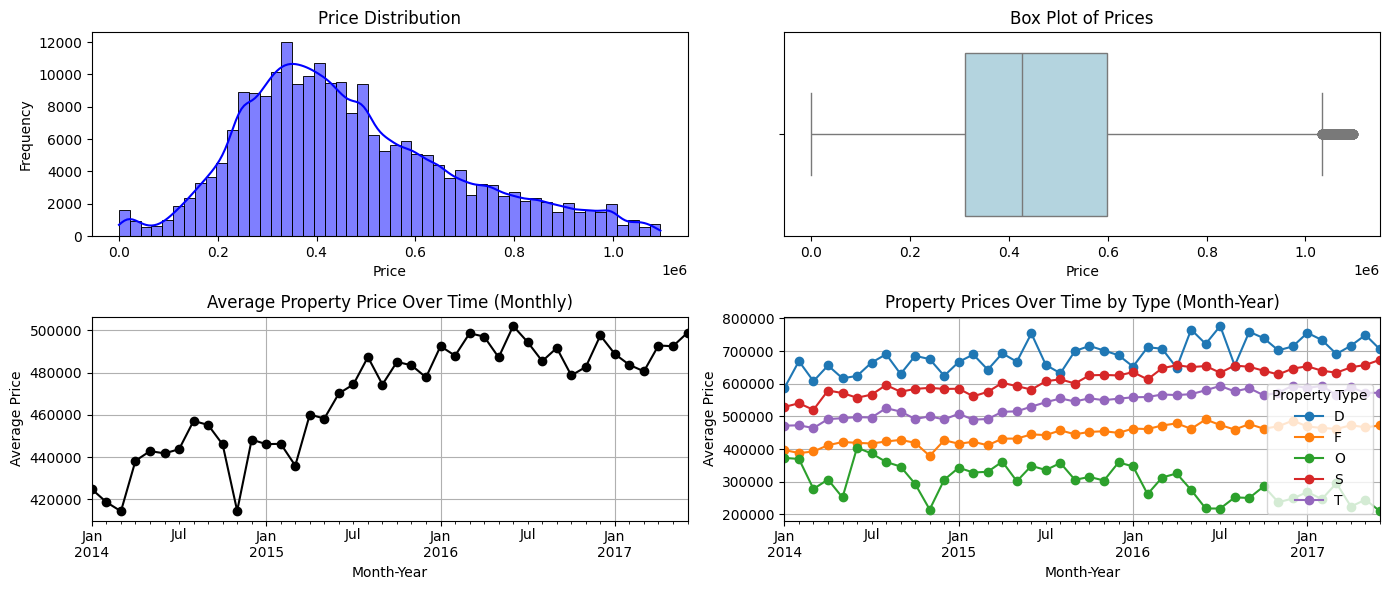

In [267]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Plot 1: Price Distribution (Histogram and KDE)
sns.histplot(data['Price'], kde=True, bins=50, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Box Plot to Detect Outliers
sns.boxplot(x=data['Price'], color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Prices')
axes[0, 1].set_xlabel('Price')

# Plot 3: Time Series Analysis of Average Prices (Monthly)
data['Month-Year'] = data['Date of Transfer'].dt.to_period('M')  # Create Month-Year column

# Group by Month-Year and calculate the average price
avg_price_by_month = data.groupby('Month-Year')['Price'].mean()

# Plot the average price over time by month
avg_price_by_month.plot(kind='line', marker='o', color='black', ax=axes[1, 0])
axes[1, 0].set_title('Average Property Price Over Time (Monthly)')
axes[1, 0].set_xlabel('Month-Year')
axes[1, 0].set_ylabel('Average Price')
axes[1, 0].grid(True)

# Plot 4: Different Property Prices Over Time (Month-by-Month for Every Year)
# Group by Month-Year and Property Type to get the average price
avg_price_by_month_property_type = data.groupby(['Month-Year', 'Property Type'])['Price'].mean().unstack()

# Plot the average prices for each Property Type over each month of each year
avg_price_by_month_property_type.plot(kind='line', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Property Prices Over Time by Type (Month-Year)')
axes[1, 1].set_xlabel('Month-Year')
axes[1, 1].set_ylabel('Average Price')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


The code generates a **2x2 grid of visualizations** to explore different aspects of the house price dataset. It helps to better understand the distribution of house prices, detect potential outliers, and observe trends over time. Here's a breakdown of each subplot:

---

### **1. Price Distribution (Histogram and KDE)**
- This plot shows the **distribution of house prices** using a histogram combined with a Kernel Density Estimate (KDE). The histogram divides the data into 50 bins, and the KDE curve helps visualize the smooth distribution of house prices. This allows us to see the frequency of prices at different price points and gives an insight into whether the data is skewed or follows a particular distribution.
  
---

### **2. Box Plot to Detect Outliers**
- The **box plot** of house prices is used to visually detect outliers. It shows the median, quartiles, and potential outliers for the `Price` column. Outliers appear as points outside the whiskers of the box plot, providing a quick way to identify unusually high or low prices in the dataset. This is particularly useful after handling outliers during the data cleaning process, as it helps to verify whether any extreme price values remain in the data.

---

### **3. Time Series Analysis of Average Prices (Monthly)**
- This plot represents the **average property price over time**, calculated monthly. A new column, `Month-Year`, is created from the `Date of Transfer`, which allows the data to be grouped by month and year. The resulting line plot shows how the average property prices have changed month by month over the years in the dataset. This visualization is key for detecting trends, seasonal fluctuations, or any general increase or decrease in property values over time.

---

### **4. Property Prices Over Time by Type**
- This final plot provides a deeper look at how **property prices vary by type** over time. The dataset is grouped by both `Month-Year` and `Property Type`, calculating the average price for each group. The line plot displays the price trends for different property types across the months, allowing for comparisons of how various property categories (e.g., detached, semi-detached, terraced, flats) have appreciated or depreciated over time.

---

### **Insights from the Visualizations**
- The **Price Distribution** and **Box Plot** provide foundational insights into the spread of the data and highlight potential outliers.
- The **Time Series Analysis** allows for trend analysis over time, showing the general movement of property prices.
- The **Property Prices by Type** plot reveals how different property types respond to market conditions, which could suggest varying demand or market trends for different types of properties.

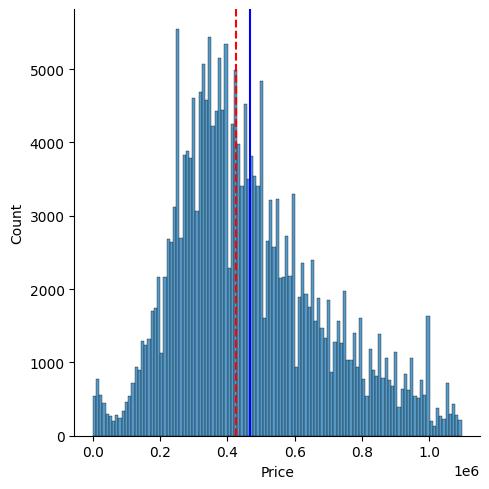

In [268]:
data_mean = data["Price"].mean()
data_median = data["Price"].median()

sns.displot(data = data, x = 'Price')
plt.axvline(x = data_mean, color = 'Blue')
plt.axvline(x = data_median, color = "Red", linestyle = '--')

This visualization helps to compare how the mean and median relate to the overall distribution of prices. The mean line indicates the average price, while the median line shows the middle point of the distribution, helping to highlight if the data is skewed.


## Cleansing Data
For creating the models we wil need to format and structurize our data correctly.

In [269]:
data.drop(columns=['Date of Transfer', 'Transaction unique identifier','Town/City', 'Record Status - monthly file only'], axis = 1, inplace = True)
data.head()

,Price,Property Type,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year
0,830000,D,N,F,BARNET,GREATER LONDON,A,2014,10,27,2014-10
1,800000,S,N,F,BARNET,GREATER LONDON,A,2014,12,22,2014-12
2,560500,T,N,F,BARNET,GREATER LONDON,A,2014,9,18,2014-09
4,682500,F,N,L,CITY OF WESTMINSTER,GREATER LONDON,A,2014,6,20,2014-06
5,360000,F,Y,L,GREENWICH,GREATER LONDON,A,2014,7,24,2014-07


The dataset is further **cleaned and structured** by removing irrelevant columns such as `Date of Transfer`, `Transaction unique identifier`, `Town/City`, and `Record Status - monthly file only`. This simplifies the dataset, retaining only the essential features for analysis. Additionally, the `Property Type` column is one-hot encoded, creating binary columns for each property type, making it suitable for machine learning models. The final cleaned dataset is now structured with 14 columns, ready for further analysis or model creation.

In [270]:
# One-hot encode 'property_type' without dropping any category
data = pd.get_dummies(data, columns=['Property Type'], drop_first=False)

# Convert boolean columns (if they exist) to integers (1s and 0s)
property_type_columns = data.filter(like='Property Type_').columns
data[property_type_columns] = data[property_type_columns].astype(int)

# Drop irrelevant category 'Property Type_O'
if 'Property Type_O' in data.columns:
    data = data.drop(columns=['Property Type_O'])

# Verify columns
print(data.filter(like='Property Type_').head())



   Property Type_D  Property Type_F  Property Type_S  Property Type_T
0                1                0                0                0
1                0                0                1                0
2                0                0                0                1
4                0                1                0                0
5                0                1                0                0


It continues from the previous step by **one-hot encoding** the `Property Type` column, creating separate columns for each property type (e.g., `Property Type_D`, `Property Type_F`). It then converts any boolean values to integers (0s and 1s). The `Property Type_O` column, which is considered unnecessary, is dropped. This results in a cleaner dataset with distinct columns for each property type.

In [271]:
# Filter columns starting with "Property Type_"
property_type_columns = data.filter(like='Property Type_')

# Count the number of entries for each property type (sum the True/1 values in each column)
property_type_counts = property_type_columns.sum()

# Display the counts
print(property_type_counts)

# Replace 'N' with 0 and 'Y' with 1 directly in the 'old/new' column
data['Old/New'] = data['Old/New'].replace({'N': 0, 'Y': 1})

# Replace 'F' with 0 and 'L' with 1 directly in the 'Duration' column
data['Duration'] = data['Duration'].replace({'F': 0, 'L': 1})

# Replace 'A' with 0 and '1' with 1 directly in the 'PPDCategory Type' column
data['PPDCategory Type'] = data['PPDCategory Type'].replace({'A': 0, 'B': 1})

# Check the updated DataFrame
data.head()

Property Type_D      1968
Property Type_F    156249
Property Type_S     11242
Property Type_T     45073
dtype: int64


,Price,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year,Property Type_D,Property Type_F,Property Type_S,Property Type_T
0,830000,0,0,BARNET,GREATER LONDON,0,2014,10,27,2014-10,1,0,0,0
1,800000,0,0,BARNET,GREATER LONDON,0,2014,12,22,2014-12,0,0,1,0
2,560500,0,0,BARNET,GREATER LONDON,0,2014,9,18,2014-09,0,0,0,1
4,682500,0,1,CITY OF WESTMINSTER,GREATER LONDON,0,2014,6,20,2014-06,0,1,0,0
5,360000,1,1,GREENWICH,GREATER LONDON,0,2014,7,24,2014-07,0,1,0,0


 First, it calculates the number of occurrences for each property type (based on the one-hot encoded columns) by summing the values in each of the newly created `Property Type_` columns, and then displays these counts. It also performs direct replacements in other columns: it replaces 'N' with 0 and 'Y' with 1 in the Old/New column, 'F' with 0 and 'L' with 1 in the Duration column, and 'A' with 0 and 'B' with 1 in the PPDCategory Type column. The updated dataset is then displayed, with the changes reflected in the relevant columns.

In [272]:
price_mean = data["Price"].mean()
price_median = data["Price"].median()

print('Mean:', price_mean)
print("Median:", price_median)

Mean: 467391.0389903894
Median: 426000.0


In [273]:
lin_df = data.copy()

lin_df['District'] = lin_df['District'].factorize()[0].astype('float32')
lin_df['County'] = lin_df['County'].factorize()[0].astype('float32')


lin_df

,Price,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year,Property Type_D,Property Type_F,Property Type_S,Property Type_T
0,830000,0,0,0.0,0.0,0,2014,10,27,2014-10,1,0,0,0
1,800000,0,0,0.0,0.0,0,2014,12,22,2014-12,0,0,1,0
2,560500,0,0,0.0,0.0,0,2014,9,18,2014-09,0,0,0,1
4,682500,0,1,1.0,0.0,0,2014,6,20,2014-06,0,1,0,0
5,360000,1,1,2.0,0.0,0,2014,7,24,2014-07,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252742,785000,0,1,22.0,0.0,0,2017,4,5,2017-04,0,1,0,0
252743,640000,0,1,19.0,0.0,0,2017,3,31,2017-03,0,1,0,0
252744,490000,0,1,22.0,0.0,0,2017,3,24,2017-03,0,1,0,0
252745,758000,0,0,6.0,0.0,0,2017,5,19,2017-05,0,0,0,1


In [274]:
feat_cols = ['District', 'County','Old/New', 'Duration', 'Year', 'Month', 'Property Type_D', 'Property Type_F', 'Property Type_S', 'Property Type_T'
             , 'PPDCategory Type']

In [275]:
X = lin_df[feat_cols]
y = lin_df['Price']

X['Year'] = X['Year'].astype(str).astype(int)
X['Year'].dtype

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_23604\2474983789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Year'] = X['Year'].astype(str).astype(int)


dtype('int32')

## Creating the Models
Models that will be created: Linear Regression & Decision Tree

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

The code begins by preparing the dataset for machine learning. First, the data is split into training and testing sets using `train_test_split()`, with 20% of the data reserved for testing. It then standardizes the features in the training set using `StandardScaler()`, which transforms the data to have a mean of 0 and a standard deviation of 1. This step is important for models that are sensitive to the scale of the input features, like Linear Regression.

In [277]:
scaler = StandardScaler()

normalized_array = scaler.fit_transform(X_train[feat_cols])
normalized_X_train = pd.DataFrame(normalized_array, columns=feat_cols)

normalized_X_train

,District,County,Old/New,Duration,Year,Month,Property Type_D,Property Type_F,Property Type_S,Property Type_T,PPDCategory Type
0,-1.507990,-0.01505,-0.422425,-1.668587,-1.193736,-0.932925,-0.093997,-1.557692,-0.231583,1.976894,-0.38929
1,2.704307,-0.01505,-0.422425,-1.668587,-1.193736,1.398516,-0.093997,-1.557692,-0.231583,1.976894,-0.38929
2,0.364142,-0.01505,-0.422425,-1.668587,-0.170570,0.815656,-0.093997,-1.557692,-0.231583,1.976894,-0.38929
3,0.676164,-0.01505,-0.422425,0.599310,-0.170570,1.107086,-0.093997,0.641975,-0.231583,-0.505844,-0.38929
4,-0.727935,-0.01505,-0.422425,0.599310,-0.170570,1.398516,-0.093997,0.641975,-0.231583,-0.505844,-0.38929
...,...,...,...,...,...,...,...,...,...,...,...
176633,0.208131,-0.01505,-0.422425,0.599310,0.852596,-0.932925,-0.093997,0.641975,-0.231583,-0.505844,-0.38929
176634,1.456219,-0.01505,-0.422425,0.599310,-0.170570,-1.224356,-0.093997,0.641975,-0.231583,-0.505844,-0.38929
176635,-1.507990,-0.01505,2.367283,0.599310,0.852596,-0.350065,-0.093997,0.641975,-0.231583,-0.505844,-0.38929
176636,1.144197,-0.01505,-0.422425,0.599310,-1.193736,-1.224356,-0.093997,0.641975,-0.231583,-0.505844,-0.38929


### Linear Regression

In [278]:
kf = KFold(n_splits = 5, random_state = None)

lreg = LinearRegression()
     
avg_lreg_score = cross_val_score(lreg , normalized_X_train, y_train, cv = kf)

The code sets up a **5-fold cross-validation** using `KFold()` to evaluate the model's performance. A **Linear Regression** model is initialized and trained using the training data (`X_train` and `y_train`). The model is evaluated on the test set (`X_test`) by generating predictions (`y_pred_lr`). The performance of the linear regression model is then assessed using two metrics: **Mean Squared Error (MSE)**, which measures the average squared differences between predicted and actual values, and **R² Score**, which evaluates how well the model fits the data

In [279]:
# Train het lineaire regressiemodel
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print('Avg accuracy : {}'.format(avg_lreg_score))
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Avg accuracy : [0.12803451 0.13223167 0.13181578 0.13422602 0.13080135]
Mean Squared Error: 41474216766.900185
R² Score: 0.13251913886734878


The linear regression model is trained using the training data (`X_train`, `y_train`) and then makes predictions on the test data (`X_test`). It evaluates the model's performance by calculating the Mean Squared Error (MSE) and R² score, which are common metrics for regression models. The average accuracy from cross-validation is also printed. The results, including the MSE and R² score, indicate the model's performance, where a higher R² and lower MSE would indicate a better fit.

### Decision tree

In [280]:
kf = KFold(n_splits = 5, random_state = None)

tr_regressor = DecisionTreeRegressor(random_state = 42)

avg_tr_score = cross_val_score(tr_regressor, normalized_X_train, y_train, cv = kf)

The first part of the code uses KFold cross-validation with 5 splits to evaluate the performance of a Decision Tree Regressor model. It calculates the average accuracy by applying cross-validation on the training data (`normalized_X_train` and `y_train`). This process helps assess how the model performs across different subsets of the data, providing an average score to indicate its generalizability.

In [281]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)

print('Avg accuracy : {}'.format(avg_tr_score))
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Avg accuracy : [0.3446826  0.3511288  0.35316566 0.34875854 0.34909396]
Mean Squared Error: 30579882961.663246
R² Score: 0.3603866384261558


A **Decision Tree Regressor** model is trained on the full training set (`X_train`, `y_train`). The model is then used to make predictions on the test data (`X_test`). The performance is evaluated by calculating the Mean Squared Error (MSE) and R² score, which measure the accuracy of the predictions and the goodness of fit, respectively. The code outputs the average accuracy from the cross-validation, as well as the MSE and R² score for the model's predictions on the test data.

## Determining if the models are good

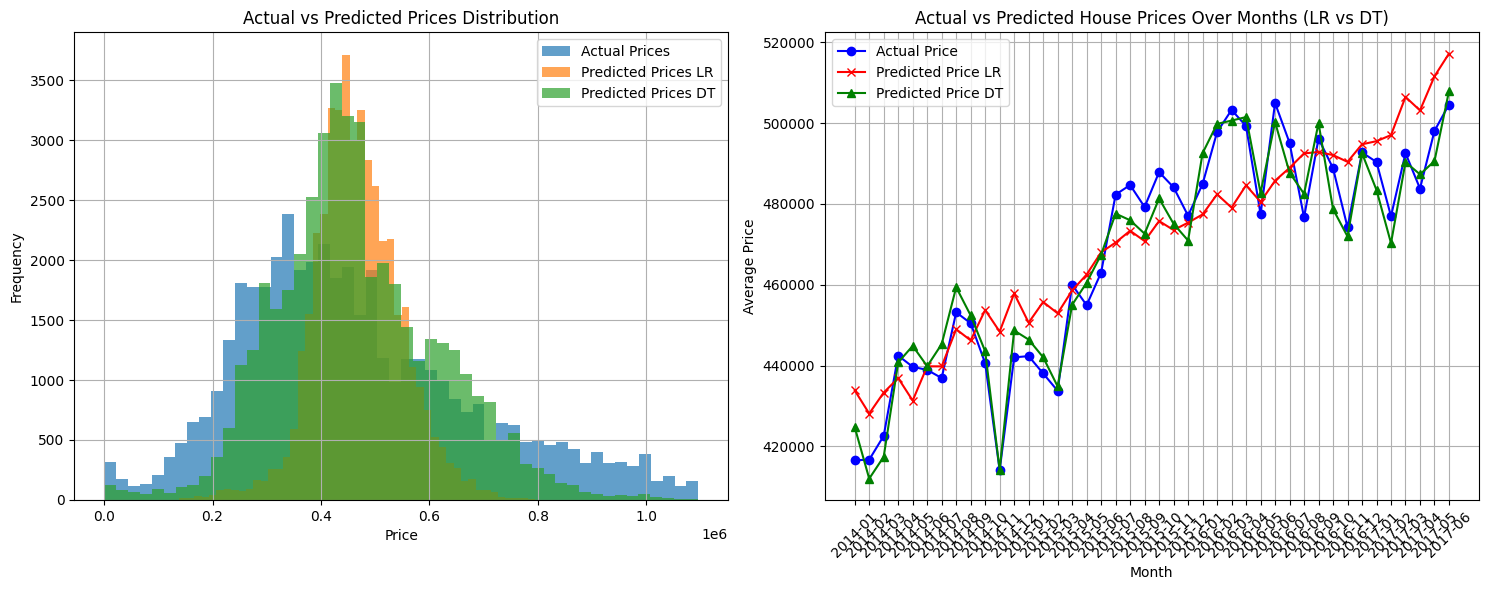

In [282]:
# Create a 1x2 subplot layout (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 1: Price Distribution (Histogram) with Actual and Predicted Prices (Linear Regression and Decision Tree)
ax[0].hist(y_test, bins=50, alpha=0.7, label='Actual Prices')
ax[0].hist(y_pred_lr, bins=50, alpha=0.7, label='Predicted Prices LR')
ax[0].hist(y_pred_dt, bins=50, alpha=0.7, label='Predicted Prices DT')
ax[0].legend(loc='upper right')
ax[0].set_title("Actual vs Predicted Prices Distribution")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")
ax[0].grid(True)

# Create 'year_month' by formatting Year and Month as YYYY-MM
X_test['Year_Month'] = X_test['Year'].astype(str) + '-' + X_test['Month'].astype(str).str.zfill(2)

# Combine Actual and Predicted Prices with the Year_Month for Plot 2
result_df = pd.DataFrame({
    'Year_Month': X_test['Year_Month'],  # year_month as string format YYYY-MM
    'Actual Price': y_test,  # Actual prices
    'Predicted Price LR': y_pred_lr,  # Predicted prices from Linear Regression
    'Predicted Price DT': y_pred_dt  # Predicted prices from Decision Tree
})

# Group by Year_Month and calculate the average prices for plotting
result_df_grouped = result_df.groupby('Year_Month').agg({
    'Actual Price': 'mean',
    'Predicted Price LR': 'mean',
    'Predicted Price DT': 'mean'
}).reset_index()

# Plot 2: Actual vs Predicted House Prices Over Months (LR vs DT)
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Actual Price'], label='Actual Price', color='blue', marker='o')
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Predicted Price LR'], label='Predicted Price LR', color='red', marker='x')
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Predicted Price DT'], label='Predicted Price DT', color='green', marker='^')

# Adding titles and labels for Plot 2
ax[1].set_title('Actual vs Predicted House Prices Over Months (LR vs DT)')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Price')
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility
ax[1].legend()
ax[1].grid(True)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the combined plots
plt.show()


#### First plot 'Actual vs Predicted Prices Distribution'
1. **Actual Prices:** These represent the real property prices from the test dataset (`y_test`).
2. **Predicted Prices from Linear Regression:** These are the property prices predicted by the Linear Regression model (`y_pred_lr`).
3. **Predicted Prices from Decision Tree:** These are the property prices predicted by the Decision Tree model (`y_pred_dt`).

**prediction accuracy:** How closely the predicted prices (both from Linear Regression and Decision Tree) follow the actual price distribution. 

#### Second Plot: Actual vs Predicted Prices Over Months (LR vs DT)
The lines in the plot will show:

    - How closely each model's predictions align with the actual prices over time.
    - The trend of property prices over time, including any noticeable patterns or seasonality.
    - Whether one model is consistently overestimating or underestimating prices compared to the actual data.

#### Conclusion:

The Decision Tree Regressor outperforms the Linear Regression model in predicting property prices, as evidenced by its lower error rate (MSE) and higher explanatory power (R² score). This suggests that Decision Trees better capture the complex relationships and non-linear patterns present in the property price dataset. Therefore, the Decision Tree model would be the preferred choice for prediction in this scenario.